In [3]:
import ktrain
from ktrain import text as ktext
from datasets import load_dataset
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split


In [4]:
# Load dataset from Hugging Face's datasets
dataset = load_dataset("dair-ai/emotion")

train = dataset['train']
val = dataset['validation']
test = dataset['test']

class_names = ['sadness', 'joy', 'love', 'anger', 'fear' , 'surprise']
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels
tweets_train, labels_train = get_tweets(train)
tweets_val, labels_val = get_tweets(val)


In [5]:
# Prepare BERT input using ktrain's utility
from ktrain import text
(x_train, y_train), (x_val, y_val), preproc = ktext.texts_from_array(
    x_train=tweets_train, y_train=labels_train,
    x_test=tweets_val, y_test=labels_val,
    class_names=class_names,
    preprocess_mode='bert',
    maxlen=256,  # This maxlen should match the sequence length expected by the LSTM
    max_features=35000
)
# Load the BERT model pre-trained for classification with ktrain
model = ktext.text_classifier('bert', train_data=(x_train, y_train), preproc=preproc)
model.summary()


preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification
Is Multi-Label? False
maxlen is 256


/Users/samanodyjr/Library/Python/3.8/lib/python/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


done.
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input-Token (InputLayer)    [(None, 256)]                0         []                            
                                                                                                  
 Input-Segment (InputLayer)  [(None, 256)]                0         []                            
                                                                                                  
 Embedding-Token (TokenEmbe  [(None, 256, 768),           2344089   ['Input-Token[0][0]']         
 dding)                       (30522, 768)]               6                                       
                                                                                                  
 Embedding-Segment (Embeddi  (None, 256, 768)             1536      ['Input-Segment[0]

In [6]:
#Increasing neurons per layer
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GRU


# Assuming 'bert_sequence_output' is from the last BERT layer
bert_sequence_output = model.layers[3].output

# Build stacked Bi-LSTM part
bi_lstm_1 = Bidirectional(LSTM(256, return_sequences=True))(bert_sequence_output)
bi_lstm_2 = Bidirectional(LSTM(256, return_sequences=True))(bi_lstm_1)
gru_layer = Bidirectional(GRU(256, return_sequences=True))(bi_lstm_2)  # Add a GRU layer here
bi_lstm_3 = Bidirectional(LSTM(256, return_sequences=True))(gru_layer)
bi_lstm_4 = Bidirectional(LSTM(256, return_sequences=True))(bi_lstm_3)
gru_layer = Bidirectional(GRU(256, return_sequences=True))(bi_lstm_4)
bi_lstm_5 = Bidirectional(LSTM(256, return_sequences=True))(bi_lstm_4)
bi_lstm_6 = Bidirectional(LSTM(256))(bi_lstm_5)    # The last LSTM layer should not return sequences

# Adding a dropout layer for regularization
dropout = Dropout(0.5)(bi_lstm_6)

# Output layer
output_layer = Dense(6, activation='softmax')(dropout)

# Construct the final model
hybrid_model = Model(inputs=model.input, outputs=output_layer)
hybrid_model.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
hybrid_model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input-Segment (InputLayer)  [(None, 256)]                0         []                            
                                                                                                  
 Embedding-Segment (Embeddi  (None, 256, 768)             1536      ['Input-Segment[0][0]']       
 ng)                                                                                              
                                                                                                  
 bidirectional (Bidirection  (None, 256, 512)             2099200   ['Embedding-Segment[0][0]']   
 al)                                                                                              
                                                                                            

In [7]:
print(y_train.shape)
print(y_val.shape)

(16000, 6)
(2000, 6)


In [7]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=12,
    restore_best_weights=True
)


history = hybrid_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=5,
    batch_size=64,
    callbacks=[early_stopping_callback]
)

Epoch 1/5
250/250 [==============================] - 9517s 38s/step - loss: 1.6185 - accuracy: 0.3133 - val_loss: 1.5970 - val_accuracy: 0.3520
Epoch 2/5
250/250 [==============================] - 9141s 37s/step - loss: 1.5851 - accuracy: 0.3282 - val_loss: 1.5912 - val_accuracy: 0.3520
Epoch 3/5
210/250 [========================>.....] - ETA: 22:18 - loss: 1.5834 - accuracy: 0.3304

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt


In [16]:
# Predict the probabilities for each class
y_pred_probs = hybrid_model.predict(x_val)
# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)


63/63 [==============================] - 90s 1s/step


In [19]:
# Generate a classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

     sadness       0.00      0.00      0.00       550
         joy       0.35      1.00      0.52       704
        love       0.00      0.00      0.00       178
       anger       0.00      0.00      0.00       275
        fear       0.00      0.00      0.00       212
    surprise       0.00      0.00      0.00        81

    accuracy                           0.35      2000
   macro avg       0.06      0.17      0.09      2000
weighted avg       0.12      0.35      0.18      2000



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Overall accuracy
accuracy = np.mean(y_pred == y_true)
print("Overall accuracy:", accuracy)

# Alternatively, you can use the accuracy_score function from sklearn
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print("Overall accuracy from sklearn:", accuracy)


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')  # 'weighted' accounts for label imbalance
print("F1 Score:", f1)

# Precision and Recall
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
print("Precision:", precision)
print("Recall:", recall)


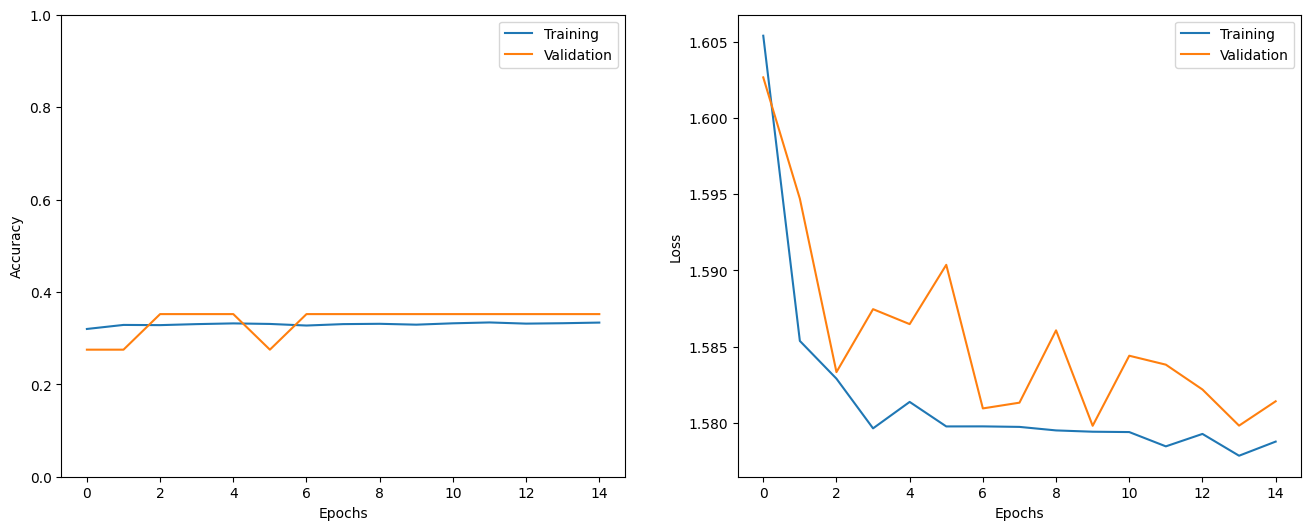

In [18]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def show_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, len(classes))), labels=classes)
    plt.yticks(list(range(0, len(classes))), labels=classes)
    plt.colorbar(ctx)
    plt.show()


# Show training history
show_history(history)

# Show confusion matrix
